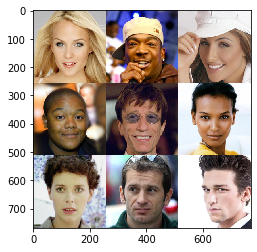

In [1]:
import helper
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
from PIL import Image
import numpy as np
import random

data_dir = './data'
IMAGE_HEIGHT_HIGH = 256
IMAGE_WIDTH_HIGH = 256
data_files_high = glob(os.path.join(data_dir, 'out_highres/*.jpg'))
attrib_files=glob(os.path.join(data_dir, 'attributes/*.txt'))
shape_high = len(data_files_high), IMAGE_WIDTH_HIGH, IMAGE_HEIGHT_HIGH, 3
def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    """
    image = Image.open(image_path)


    return np.array(image.convert(mode))

def get_attrib(attrib_path):
    file=open(attrib_path,"rt")
    attributes=list(map(int,file.readline().split()))
    file.close()
    return attributes

def get_batch(image_files, width, height, mode='RGB'):
    """
    Get a single image
    """
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch


#print(get_attrib_batch(glob(os.path.join(data_dir, 'attributes/*.txt')))[:10])
test_images_high = get_batch(glob(os.path.join(data_dir, 'out_highres/*.jpg'))[:10], 56, 56)
pyplot.imshow(helper.images_square_grid(test_images_high))
#test_images_low = get_batch(glob(os.path.join(data_dir, 'out/*.jpg'))[:10], 56, 56)
#pyplot.imshow(helper.images_square_grid(test_images_low))

In [2]:
import tensorflow as tf


from tensorflow.python.tools import inspect_checkpoint as chkp

def model_inputs(image_width_high, image_height_high,image_channels):
    """
    Create the model inputs
    """
    noise = tf.placeholder(tf.float32, (None, 100), name='input_z')
    inputs_high = tf.placeholder(tf.float32, shape=(None, image_width_high, image_height_high, image_channels), name='inputa_high') 
    attribs=tf.placeholder(tf.float32, (None, 40), name='input_z')
    
    return attribs,noise,inputs_high

In [3]:
def generator(z,attribs, out_channel_dim, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x_1 = tf.layers.dense(attribs, 512)
        lrelu_x = tf.maximum(alpha * x_1, x_1)
        z_1=tf.layers.dense(z, 128)
        lrelu_z = tf.maximum(alpha * z_1, z_1)
        con=tf.concat([lrelu_x,lrelu_z],1)
        con_1=tf.layers.dense(con,128 * 4 * 4 * 4)
        con_relu = tf.maximum(alpha * con_1,con_1)
        
        
        
        
        # Reshape it to start the convolutional stack
        x = tf.reshape(con_relu, (-1, 4, 4, 128*4))
        # Deconv 1
        x=tf.keras.layers.UpSampling2D(size=(2, 2))(x)
        x = tf.layers.conv2d(x, 256, 5, 1, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(x, 256, 5, 1, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x=tf.keras.layers.UpSampling2D(size=(2, 2))(x)
        x = tf.layers.conv2d(x, 128, 5, 1, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        
        # Deconv 2
        x=tf.keras.layers.UpSampling2D(size=(2, 2))(x)
        x = tf.layers.conv2d(x,64, 5, 1, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x=tf.keras.layers.UpSampling2D(size=(2, 2))(x)
        x = tf.layers.conv2d(x, 32, 5, 1, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        # Output layer
        logits = tf.layers.conv2d(x, out_channel_dim, 4, 1, padding='SAME')
        out = tf.tanh(logits)
        return out

In [4]:
def residual_block(inp,is_train):

    x=tf.layers.conv2d(inp,256,3,1,padding='SAME')
    x = tf.layers.batch_normalization(x, training=is_train)
    x = tf.maximum(0.2 * x, x)
    x=tf.layers.conv2d(x,256,3,1,padding='SAME')
    x = tf.layers.batch_normalization(x, training=is_train)
    x=tf.math.add(inp,x)
    x = tf.maximum(0.2 * x, x)

    return x

In [5]:
def generator_stage2(z,attribs,out_channel_dim, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.2
    with tf.variable_scope('generator_stage2', reuse=False if is_train==True else True):
        at=tf.layers.dense(attribs,512)
        at = tf.maximum(alpha * at,at)
        
        at= tf.layers.dense(at,64*16*16)
        at = tf.maximum(alpha * at,at)
        
        at =tf.reshape(at,(-1,16,16,64))

        x=tf.layers.conv2d(z, 128, 4, 2, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        
        x=tf.layers.conv2d(x,256, 4, 2, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        
   
        x= tf.concat([x,at],3)
    
        x=tf.layers.conv2d(x,256, 4, 1, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
    
        x=residual_block(x,is_train)
        x=residual_block(x,is_train)
        x=residual_block(x,is_train)
        x=residual_block(x,is_train)
    
    

        
        

        x=tf.layers.conv2d_transpose(x, 128, 4, 2, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        
        

        #print(x)
        # Deconv 1
        x = tf.layers.conv2d_transpose(x, 64, 5, 2, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)

        
        x = tf.layers.conv2d_transpose(x, 32, 5, 2, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        # Deconv 2
        x = tf.layers.conv2d_transpose(x,16, 5, 2, padding='SAME')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)

        # Output layer
        
        x = tf.layers.conv2d(x, out_channel_dim, 3, 1, padding='SAME')
        x = tf.tanh(x)

        return x

In [6]:
def show_generator_output(sess, n_images,input_z,attribs,out_channel_dim):
    """
    Show example output for the generator
    """
    f=open("/Studies/GANs/dcgan-oreilly/data/CelebAMask-HQ-attribute-anno.txt","rt")
    no_of_images=int(f.readline())
    attribute_names=list(f.readline().split())
    names=[]
    example_attribs=np.random.randint(0, 2, size=[1, 40])*2-1
    for n in range(40):
        if example_attribs[0,n]==1:
            names.append(attribute_names[n])

    
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    example_z= example_z.astype('float32')
    images_low=generator(input_z,attribs,out_channel_dim, False)
    samples_high = sess.run(
        generator_stage2(images_low,attribs,out_channel_dim, False),
        feed_dict={attribs:example_attribs,input_z: example_z})
    print(names)
    pyplot.imshow(helper.images_square_grid(samples_high))
    pyplot.show()

In [7]:
def predict(data_shape_high):
    tf.reset_default_graph()
    v1=tf.get_variable("generator/dense/kernel", (40,512))
    v2=tf.get_variable("generator/dense/bias", (512,))
    v3=tf.get_variable("generator/dense_1/kernel", (100,128))
    v4=tf.get_variable("generator/dense_1/bias", (128,))
    v5=tf.get_variable("generator/dense_2/kernel", (640,8192))
    v6=tf.get_variable("generator/dense_2/bias", (8192,))
    v7=tf.get_variable("generator/conv2d/kernel", (5, 5, 512, 256))
    v8=tf.get_variable("generator/conv2d/bias", (256,))
    v9=tf.get_variable("generator/batch_normalization/gamma", (256,))
    v10=tf.get_variable("generator/batch_normalization/beta", (256,))
    v9_1=tf.get_variable("generator/batch_normalization/moving_mean",(256,))
    v9_2=tf.get_variable("generator/batch_normalization/moving_variance",(256,))
    v11=tf.get_variable("generator/conv2d_1/kernel", (5, 5, 256, 256))
    v12=tf.get_variable("generator/conv2d_1/bias", (256,))
    v13=tf.get_variable("generator/batch_normalization_1/gamma", (256,))
    v14=tf.get_variable("generator/batch_normalization_1/beta", (256,))
    v14_1=tf.get_variable("generator/batch_normalization_1/moving_mean",(256,))
    v14_2=tf.get_variable("generator/batch_normalization_1/moving_variance",(256,))
    v15=tf.get_variable("generator/conv2d_2/kernel", (5, 5, 256, 128))
    v16=tf.get_variable("generator/conv2d_2/bias", (128,))
    v17=tf.get_variable("generator/batch_normalization_2/gamma", (128,))
    v18=tf.get_variable("generator/batch_normalization_2/beta", (128,))
    v18_1=tf.get_variable("generator/batch_normalization_2/moving_mean",(128,))
    v18_2=tf.get_variable("generator/batch_normalization_2/moving_variance",(128,))
    v19=tf.get_variable("generator/conv2d_3/kernel", (5, 5, 128, 64))
    v20=tf.get_variable("generator/conv2d_3/bias", (64,))
    v21=tf.get_variable("generator/batch_normalization_3/gamma", (64,))
    v22=tf.get_variable("generator/batch_normalization_3/beta", (64,))
    v22_1=tf.get_variable("generator/batch_normalization_3/moving_mean",(64,))
    v22_2=tf.get_variable("generator/batch_normalization_3/moving_variance",(64,))
    v23=tf.get_variable("generator/conv2d_4/kernel", (5, 5, 64, 32))
    v24=tf.get_variable("generator/conv2d_4/bias", (32,))
    v25=tf.get_variable("generator/batch_normalization_4/gamma", (32,))
    v26=tf.get_variable("generator/batch_normalization_4/beta", (32,))
    v26_1=tf.get_variable("generator/batch_normalization_4/moving_mean",(32,))
    v26_2=tf.get_variable("generator/batch_normalization_4/moving_variance",(32,))
    v27=tf.get_variable("generator/conv2d_5/kernel", (4, 4, 32, 3))
    v28=tf.get_variable("generator/conv2d_5/bias", (3,))
    v29=tf.get_variable("generator_stage2/dense/kernel",(40, 512))
    v30=tf.get_variable("generator_stage2/dense/bias",(512,))
    v31=tf.get_variable("generator_stage2/dense_1/kernel",(512, 16384))
    v32=tf.get_variable("generator_stage2/dense_1/bias",(16384,))
    v33=tf.get_variable("generator_stage2/conv2d/kernel",(4, 4, 3, 128))
    v34=tf.get_variable("generator_stage2/conv2d/bias",(128,))
    v35=tf.get_variable("generator_stage2/batch_normalization/gamma",(128,))
    v36=tf.get_variable("generator_stage2/batch_normalization/beta",(128,))
    v35_1=tf.get_variable("generator_stage2/batch_normalization/moving_mean",(128,))
    v36_1=tf.get_variable("generator_stage2/batch_normalization/moving_variance",(128,))
    v37=tf.get_variable("generator_stage2/conv2d_1/kernel",(4, 4, 128, 256))
    v38=tf.get_variable("generator_stage2/conv2d_1/bias",(256,))
    v39=tf.get_variable("generator_stage2/batch_normalization_1/gamma",(256,))
    v40=tf.get_variable("generator_stage2/batch_normalization_1/beta",(256,))
    v39_1=tf.get_variable("generator_stage2/batch_normalization_1/moving_mean",(256,))
    v40_1=tf.get_variable("generator_stage2/batch_normalization_1/moving_variance",(256,))
    v41=tf.get_variable("generator_stage2/conv2d_2/kernel",(4, 4, 320, 256))
    v42=tf.get_variable("generator_stage2/conv2d_2/bias",(256,))
    v43=tf.get_variable("generator_stage2/batch_normalization_2/gamma",(256,))
    v44=tf.get_variable("generator_stage2/batch_normalization_2/beta",(256,))
    v43_1=tf.get_variable("generator_stage2/batch_normalization_2/moving_mean",(256,))
    v44_1=tf.get_variable("generator_stage2/batch_normalization_2/moving_variance",(256,))
    v45=tf.get_variable("generator_stage2/conv2d_3/kernel",(3, 3, 256, 256))
    v46=tf.get_variable("generator_stage2/conv2d_3/bias",(256,))
    v47=tf.get_variable("generator_stage2/batch_normalization_3/gamma",(256,))
    v48=tf.get_variable("generator_stage2/batch_normalization_3/beta",(256,))
    v47_1=tf.get_variable("generator_stage2/batch_normalization_3/moving_mean",(256,))
    v48_1=tf.get_variable("generator_stage2/batch_normalization_3/moving_variance",(256,))
    v49=tf.get_variable("generator_stage2/conv2d_4/kernel",(3, 3, 256, 256))
    v50=tf.get_variable("generator_stage2/conv2d_4/bias",(256,))
    v51=tf.get_variable("generator_stage2/batch_normalization_4/gamma",(256,))
    v52=tf.get_variable("generator_stage2/batch_normalization_4/beta",(256,))
    v51_1=tf.get_variable("generator_stage2/batch_normalization_4/moving_mean",(256,))
    v52_1=tf.get_variable("generator_stage2/batch_normalization_4/moving_variance",(256,))
    v53=tf.get_variable("generator_stage2/conv2d_5/kernel",(3, 3, 256, 256))
    v54=tf.get_variable("generator_stage2/conv2d_5/bias",(256,))
    v55=tf.get_variable("generator_stage2/batch_normalization_5/gamma",(256,))
    v56=tf.get_variable("generator_stage2/batch_normalization_5/beta",(256,))
    v55_1=tf.get_variable("generator_stage2/batch_normalization_5/moving_mean",(256,))
    v56_1=tf.get_variable("generator_stage2/batch_normalization_5/moving_variance",(256,))
    v57=tf.get_variable("generator_stage2/conv2d_6/kernel",(3, 3, 256, 256))
    v58=tf.get_variable("generator_stage2/conv2d_6/bias",(256,))
    v59=tf.get_variable("generator_stage2/batch_normalization_6/gamma",(256,))
    v60=tf.get_variable("generator_stage2/batch_normalization_6/beta",(256,))
    v59_1=tf.get_variable("generator_stage2/batch_normalization_6/moving_mean",(256,))
    v60_1=tf.get_variable("generator_stage2/batch_normalization_6/moving_variance",(256,))
    v61=tf.get_variable("generator_stage2/conv2d_7/kernel",(3, 3, 256, 256))
    v62=tf.get_variable("generator_stage2/conv2d_7/bias",(256,))
    v63=tf.get_variable("generator_stage2/batch_normalization_7/gamma",(256,))
    v64=tf.get_variable("generator_stage2/batch_normalization_7/beta",(256,))
    v63_1=tf.get_variable("generator_stage2/batch_normalization_7/moving_mean",(256,))
    v64_1=tf.get_variable("generator_stage2/batch_normalization_7/moving_variance",(256,))
    v65=tf.get_variable("generator_stage2/conv2d_8/kernel",(3, 3, 256, 256))
    v66=tf.get_variable("generator_stage2/conv2d_8/bias",(256,))
    v67=tf.get_variable("generator_stage2/batch_normalization_8/gamma",(256,))
    v68=tf.get_variable("generator_stage2/batch_normalization_8/beta",(256,))
    v67_1=tf.get_variable("generator_stage2/batch_normalization_8/moving_mean",(256,))
    v68_1=tf.get_variable("generator_stage2/batch_normalization_8/moving_variance",(256,))
    v69=tf.get_variable("generator_stage2/conv2d_9/kernel",(3, 3, 256, 256))
    v70=tf.get_variable("generator_stage2/conv2d_9/bias",(256,))
    v71=tf.get_variable("generator_stage2/batch_normalization_9/gamma",(256,))
    v72=tf.get_variable("generator_stage2/batch_normalization_9/beta",(256,))
    v71_1=tf.get_variable("generator_stage2/batch_normalization_9/moving_mean",(256,))
    v72_1=tf.get_variable("generator_stage2/batch_normalization_9/moving_variance",(256,))
    v73=tf.get_variable("generator_stage2/conv2d_10/kernel",(3, 3, 256, 256))
    v74=tf.get_variable("generator_stage2/conv2d_10/bias",(256,))
    v75=tf.get_variable("generator_stage2/batch_normalization_10/gamma",(256,))
    v76=tf.get_variable("generator_stage2/batch_normalization_10/beta",(256,))
    v75_1=tf.get_variable("generator_stage2/batch_normalization_10/moving_mean",(256,))
    v76_1=tf.get_variable("generator_stage2/batch_normalization_10/moving_variance",(256,))
    v77=tf.get_variable("generator_stage2/conv2d_transpose/kernel",(4, 4, 128, 256))
    v78=tf.get_variable("generator_stage2/conv2d_transpose/bias",(128,))
    v79=tf.get_variable("generator_stage2/batch_normalization_11/gamma",(128,))
    v80=tf.get_variable("generator_stage2/batch_normalization_11/beta",(128,))
    v79_1=tf.get_variable("generator_stage2/batch_normalization_11/moving_mean",(128,))
    v80_1=tf.get_variable("generator_stage2/batch_normalization_11/moving_variance",(128,))
    v81=tf.get_variable("generator_stage2/conv2d_transpose_1/kernel",(5, 5, 64, 128))
    v82=tf.get_variable("generator_stage2/conv2d_transpose_1/bias",(64,))
    v83=tf.get_variable("generator_stage2/batch_normalization_12/gamma",(64,))
    v84=tf.get_variable("generator_stage2/batch_normalization_12/beta",(64,))
    v83_1=tf.get_variable("generator_stage2/batch_normalization_12/moving_mean",(64,))
    v84_1=tf.get_variable("generator_stage2/batch_normalization_12/moving_variance",(64,))
    v85=tf.get_variable("generator_stage2/conv2d_transpose_2/kernel",(5, 5, 32, 64))
    v86=tf.get_variable("generator_stage2/conv2d_transpose_2/bias",(32,))
    v87=tf.get_variable("generator_stage2/batch_normalization_13/gamma",(32,))
    v88=tf.get_variable("generator_stage2/batch_normalization_13/beta",(32,))
    v87_1=tf.get_variable("generator_stage2/batch_normalization_13/moving_mean",(32,))
    v88_1=tf.get_variable("generator_stage2/batch_normalization_13/moving_variance",(32,))
    v89=tf.get_variable("generator_stage2/conv2d_transpose_3/kernel",(5, 5, 16, 32))
    v90=tf.get_variable("generator_stage2/conv2d_transpose_3/bias",(16,))
    v91=tf.get_variable("generator_stage2/batch_normalization_14/gamma",(16,))
    v92=tf.get_variable("generator_stage2/batch_normalization_14/beta",(16,))
    v91_1=tf.get_variable("generator_stage2/batch_normalization_14/moving_mean",(16,))
    v92_1=tf.get_variable("generator_stage2/batch_normalization_14/moving_variance",(16,))
    v93=tf.get_variable("generator_stage2/conv2d_11/kernel",(3, 3, 16, 3))
    v94=tf.get_variable("generator_stage2/conv2d_11/bias",(3,))
    attribs,noise,input_high = model_inputs(data_shape_high[1], data_shape_high[2],data_shape_high[3])
    saver = tf.train.Saver()
    #for i, var in enumerate(saver._var_list):
        #print('Var {}: {}'.format(i, var))

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        
        saver.restore(sess, "/save_256_new/model.ckpt")
        _ = show_generator_output(sess, 1, noise,attribs,3)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /save_256_new/model.ckpt
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
['Attractive', 'Bags_Under_Eyes', 'Big_Lips', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'High_Cheekbones', 'Male', 'Mustache', 'No_Beard', 'Pointy_Nose', 'Sideburns', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Hat', 'Wearing_Necklace', 'Wearing_Necktie']


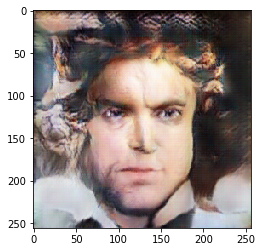

In [8]:
predict(shape_high)